In [1]:
import sys
import pandas as pd
import time
import timeit
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from LOF import *
from clean_dataframe import clean_dataframe
from clean_velocities import *

from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
from klusterointi import *

In [2]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

In [18]:
df = database_query("SELECT * FROM DATA LIMIT 500000")
df1 = df.copy()

In [4]:
df2 = df1.head(100000)

In [5]:
df2

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour
0,2,1,2020-06-25 15:21:46,28,15,628,0.962081,6812.007,3,8
1,2,1,2020-06-25 15:21:47,28,15,628,1.028834,6812.007,3,8
2,2,1,2020-06-25 15:21:47,28,15,628,0.648460,6812.007,3,8
3,2,1,2020-06-25 15:21:47,28,15,628,0.826075,6812.007,3,8
4,2,1,2020-06-25 15:21:50,26,15,626,1.753767,6812.007,3,8
...,...,...,...,...,...,...,...,...,...,...
99995,382,1,2020-09-09 18:39:26,30,27,1110,0.506063,2101.998,2,11
99996,382,1,2020-09-09 18:39:27,30,27,1110,0.478539,2101.998,2,11
99997,382,1,2020-09-09 18:39:28,30,28,1150,0.496588,2101.998,2,11
99998,382,1,2020-09-09 18:39:29,31,28,1151,0.371080,2101.998,2,11


In [19]:
distances = df.groupby(['ajokerta'])['distance'].sum().to_dict()
df["distance"] = df['ajokerta'].map(distances)
df = df.head(500000)

In [7]:
X = df2[['distance']].values
y = df2[['kesto']].values

In [8]:
#splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(80000, 1)
(20000, 1)
(80000, 1)
(20000, 1)


In [9]:
#funktio, jolla voi testata eri malleilla toimintaa ja tarkkuutta
def regressio(model):
    lin_model = model
    lin_model.fit(X_train, Y_train)
    #evaluate the model using RMSE and R2-score
# model evaluation for training set
    y_train_predict = lin_model.predict(X_train)
    rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
    r2 = r2_score(Y_train, y_train_predict)

    print("The model performance for training set", type(model).__name__)
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print("\n")

    # model evaluation for testing set
    y_test_predict = lin_model.predict(X_test)
    rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
    r2 = r2_score(Y_test, y_test_predict)

    print("The model performance for testing set")
    print("--------------------------------------")
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [11]:
regressio(LinearRegression()) #Lineaariregressio

The model performance for training set LinearRegression
--------------------------------------
RMSE is 1286.7667824183457
R2 score is 5.976021238185414e-05


The model performance for testing set
--------------------------------------
RMSE is 1277.540858288776
R2 score is 0.0002702486093488776


In [12]:
regressio(Ridge()) #Ridge

The model performance for training set Ridge
--------------------------------------
RMSE is 1286.7667824183477
R2 score is 5.9760212378745514e-05


The model performance for testing set
--------------------------------------
RMSE is 1277.5408594279156
R2 score is 0.0002702468264990099


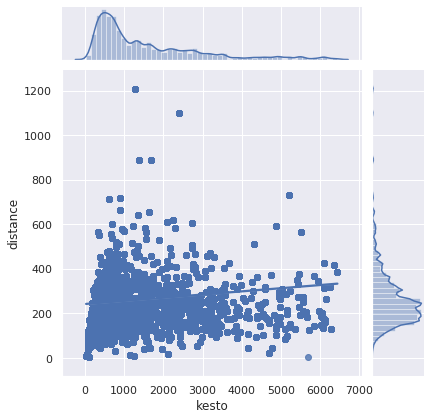

In [23]:
sns.jointplot(data=df, x='kesto', y='distance', kind='reg')

In [21]:
df.distance.max()

2316.6858099226765

In [22]:
df = df[df.kesto < 6500]

In [24]:
df = df[df.distance < 800]

In [25]:
df.distance.max()

731.2967851723196

In [26]:
X = df['distance'].to_frame() # feature-matriisi X; huomaa dataframeksi muuntaminen (to_frame)

y = df['kesto'] # target eli selitettävä/ennustettava muuttuja

In [36]:
# Tuon lineaarisen regressiomallin
from sklearn.linear_model import LinearRegression

# Sovitan mallin dataan
malli = LinearRegression().fit(X,y)
malli.score(X,y) # selityskerroin
print(malli.predict(pd.DataFrame([200])))  #ennusteet, kun x:n arvot määritellään

[1403.45181414]


In [37]:
mini = 1403/60
print(mini)

23.383333333333333
